<a href="https://colab.research.google.com/github/22Himanshu/AppliedMachineLearning/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Himanshu (MDS202328)

## Applied_ML_Spam_Classifier_1

#### Importing Libraries

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
def load_splits(data_dir):
    """Loads train, validation, and test datasets from CSV files."""
    train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    val = pd.read_csv(os.path.join(data_dir, 'validation.csv'))
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    return train, val, test


data_dir = "/content/drive/MyDrive/Applied_ML/data"
train, val, test = load_splits(data_dir)

<Axes: xlabel='label', ylabel='count'>

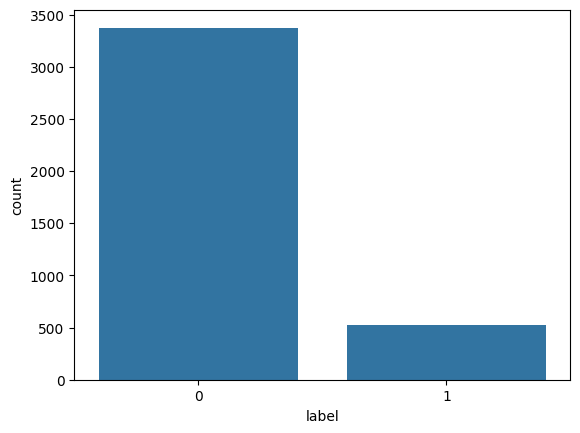

In [25]:
sns.barplot(train.iloc[:,0].value_counts())

#### The data is inbalanced. i will try to put some weightage on 1 to balance out recall

In [26]:
def vectorize_data(train, val, test):
    """Converts text data into TF-IDF vectors."""
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train['message'])
    X_val = vectorizer.transform(val['message'])
    X_test = vectorizer.transform(test['message'])
    return X_train, X_val, X_test, train['label'], val['label'], test['label'], vectorizer

X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = vectorize_data(train, val, test)

In [29]:
X_train.shape, X_val.shape, X_test.shape

((3900, 7120), (836, 7120), (836, 7120))

In [64]:
def fit_model(X_train, y_train, model):
    """Fits a model on training data."""
    model.fit(X_train, y_train, sample_weight=y_train.map({0:1,1:6}))   #sample_weight here ensures that minority gets enough representation.
    return model


In [65]:
def score_model(model, X, y):
    """Scores a model on given data."""
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred), classification_report(y, y_pred)

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Evaluates the model on both training and validation data."""
    train_acc, train_report = score_model(model, X_train, y_train)
    val_acc, val_report = score_model(model, X_val, y_val)
    print(f"{model} Training Accuracy:", train_acc)
    print(f"{model} Validation Accuracy:", val_acc)
    print(f"{model} Validation Report:\n", val_report)
    return train_acc, val_acc

def fine_tune_model(X_train, y_train, X_val, y_val):
    """Fine-tunes hyperparameters using GridSearchCV."""
    param_grid = {'C': [0.1, 1, 10, 100]}
    model = GridSearchCV(LogisticRegression(), param_grid, cv=3)
    model.fit(X_train, y_train)
    print("Best parameters:", model.best_params_)
    return model.best_estimator_

def benchmark_models(X_train, y_train, X_val, y_val, X_test, y_test):
    """Trains and evaluates multiple models, selecting the best one."""
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC()
    }
    best_model, best_acc = None, 0
    for name, model in models.items():
        model = fit_model(X_train, y_train, model)
        _, val_acc = evaluate_model(model, X_train, y_train, X_val, y_val)
        print("\n-----------------------------------------------------------------")
        print("\n")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
    test_acc, test_report = score_model(best_model, X_test, y_test)
    print(f"The best model is {best_model}")
    print("Best Model Test Accuracy:", test_acc)
    print("Test Report:\n", test_report)
    return best_model

In [66]:
best_model = benchmark_models(X_train, y_train, X_val, y_val, X_test, y_test)

MultinomialNB() Training Accuracy: 0.9910256410256411
MultinomialNB() Validation Accuracy: 0.9844497607655502
MultinomialNB() Validation Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836


-----------------------------------------------------------------


LogisticRegression() Training Accuracy: 0.9938461538461538
LogisticRegression() Validation Accuracy: 0.9880382775119617
LogisticRegression() Validation Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.97      0.94      0.95       112

    accuracy                           0.99       836
   macro avg       0.98      0.97      0.97       836
weighted avg       0.99  

## It seems performance of all three models are comparable/almost same.